###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 parts of this notebook are from ([this Jupyter notebook](https://nbviewer.jupyter.org/github/krischer/seismo_live/blob/master/notebooks/Computational%20Seismology/Wave%20Propagation%20%26%20Analytical%20Solutions/Greens_function_acoustic_1-3D.ipynb)) by Kristina Garina, Ashim Rijal and Heiner Igel ([@heinerigel](https://github.com/heinerigel)) which is a supplemenatry material to the book [Computational Seismology: A Practical Introduction](http://www.computational-seismology.org/),  additional modifications by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# Thunderstorms in 3D and 1D acoustic media

<img src="data/800px-Lightning_cloud_to_cloud.jpg" style="width: 800px;"/>

In the [previous lesson](https://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/01_Analytical_solutions/5_Greens_function_acoustic_1-3D.ipynb), we derived Greens function solutions for homogeneous acoustic 1D, 2D and 3D media. By convolving the Greens function with a known source wavelet, we are able to calculate seismograms at arbritary offsets. 

The toy examples in the last notebook illustrated the basic concept, however the medium parameters with P-wave velocities of 1 m/s were physically unrealistic. At least I have never seen a seismic wave which I can outpace by foot.

In this notebook, I want to use a more realistic example to compute wave propagation of thunder in a homogeneous 3D and 1D acoustic atmosphere, respectively. This example illustrates the shortcomings of the 1D medium approximation.

In [2]:
# Import Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.io.wavfile import read # read wav audio files
from IPython.display import Audio # play audio file in Jupyter notebook

First, we need to estimate a realistic source wavelet to model the propagation of thunder. The easiest solution is to import a wavelet from a wav-file into a numpy-array. Wavfiles can be read with the `read` function from `scipy.io.wavfile`. Beside the visualization of the resulting waveform, you can also listen to them. We only need to import the `Audio` function from `IPython.display`.

## Import thunder from wav file

Notice, that you can only read 16 bit wav-files in Python. If you want to replace the thunder example by another sound file, you can easily convert wav-files to the correct format using the open source program [Audicity](https://www.audacityteam.org/), if necessary.

So, let's try to import a "thunder sound" into this notebook:

In [3]:
# read sound file
rate, thunder = read("data/thunder.wav")

# subtract mean value
thunder = thunder - np.mean(thunder)

# normalize source wavelet 
thunder = thunder / np.amax(thunder)

# compute sample interval
dt = 1/rate

# number of time samples
nt_src = len(thunder)

# maximum time of source 
tmax_src = nt_src * dt

# define time vector for source wavelet 
time_src = np.arange(0,tmax_src,dt)

With the source time function converted into a `numpy array` and defining a time vector based on the sample interval and length of the array, we can visualize the thunder wavelet ...

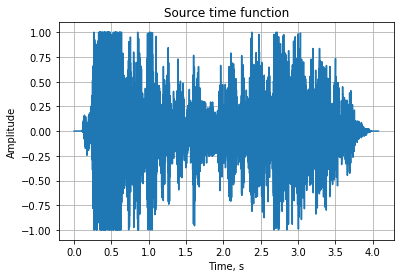

In [4]:
# Plotting of source time function
plt.plot(time_src,thunder)
plt.title('Source time function')
plt.xlabel('Time, s')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

... and check if the sound file was imported correctly, by converting the numpy-array back into a sound file:

In [5]:
Audio(thunder, rate=rate)

## Thunderstorm in 3D acoustic medium

With the source wavelet of our numerical thunderstorm, we can easily calculate the propagation of thunder in a 3D acoustic medium. 

Let me remind you that the **3D Green's function** $\mathbf{G_3(x,t;x_s,t_s)}$ for a homogenous 3D acoustic medium with constant P-wave velocity $V_{p0}$ is governed by the following partial differential equation:

\begin{equation}
\frac{\partial^2 G_3}{\partial t^2} - V_{p0}^2 \biggl(\frac{\partial^2 G_3}{\partial x^2} + \frac{\partial^2 G_3}{\partial y^2} +\frac{\partial^2 G_3}{\partial z^2} \biggl)= \delta(t-t_s) \delta(x-x_s) \delta(y-y_s) \delta(z-z_s) \nonumber
\end{equation}

where $x_s,\;y_s,\;z_s,\;t_s$ denote spatial and temporal shifts of the source position and source time wavelet, respectively. Diracs delta function $\delta(x)$ is defined as 

$$
\delta(x) = \left\{
\begin{array}{ll}
	\infty &x=0 \\
	0 &x\neq 0 	
\end{array}
\right.
$$

The solution is:

\begin{equation}
G_3(x,y,z,t) = \dfrac{1}{4 \pi V_{p0}^2 r}\delta\biggl((t-t_s)-\frac{r}{V_{p0}}\biggr) \nonumber 
\end{equation}

with the source-receiver distance (offset)

$r = \sqrt{(x-x_s)^2+(y-y_s)^2+(z-z_s)^2}$

So the 3D Green's function for the homogeneous acoustic medium is a Delta distribution delayed by the traveltime between source and receiver and is damped proportional to the offset.

To compute seismograms $G_{seis}(x,t)$ for an arbritary source wavelet, we have to convolve the Green's function $G(x,t;x_s,t_s)$ with the source wavelet $s(t)$:

$$G_{seis}(x,t) = G(x,t;x_s,t_s) * s(t)$$


In the following function, I compiled the computation of the 3D Green's function and seismogram computation for a given offset `xr`, maximum recording time `tmax`, number of time samples `nt` and a source wavelet, in this case the sound of a thunder. 

The medium properties of air, in this case the P-wave velocity vp0 = 333 m/s, is also defined in the function.

In [6]:
def calc_seis_3D(xr,tmax,nt,thunder):

    # Define P-wave velocity of air (m/s)
    vp0 = 333.

    # Acquisition geometry
    ts = 0                  # source time
    
    xs = 0                  # source position
    ys = 0
    zs = 0
    
    yr = 0                  # receiver position
    zr = 0 
    
    # Computation of 3D Green's function
    G3=np.zeros(nt)                                # initialization G with zeros
    r=np.sqrt((xs-xr)**2+(ys-yr)**2+(zs-zr)**2)   # defining offset
    amp = 1./(4*np.pi*(vp0**2)*r)                 # defining amplitudes
    t_arr=ts+(r/vp0)                              # time arrival
    i_arr=t_arr/dt
    b=int(i_arr)
    G3[b]= amp/dt
    
    # Computation of seismograms for given source wavelet
    seis = np.convolve(G3,thunder)
    seis = seis[0:nt]

    return seis    

After definition of the maximum seismogram recording time `tmax` as a multiplier of the maximum source time `tmax_src`, we can calculate the `time` vector for the final seismogram and seismogram recordings at 1 km and 0 km offset, respectively. Because the 3D Green's function becomes singular at an offset of 0 km, we replace the offset by a small value like 1 m

In [7]:
# maximum seismogram recording time
tmax = 2.0 * tmax_src   

# Define time vector
time = np.arange(0,tmax,dt)
nt = len(time)

# calculate seismograms at 0 km and 1 km offset
G3_seis_1m = calc_seis_3D(1.0,tmax,nt,thunder)
G3_seis_1km = calc_seis_3D(1000.0,tmax,nt,thunder)

The visualization of the resulting seismograms at 0 km offset ...

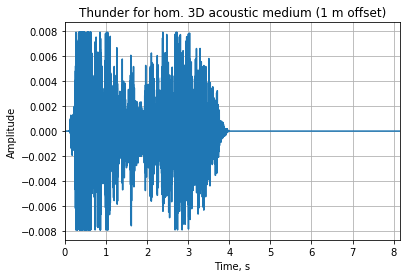

In [8]:
# Plotting Seismogram at 1 m offset
plt.plot(time, G3_seis_1m)
plt.title("Thunder for hom. 3D acoustic medium (1 m offset)" )
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.xlim((0, tmax))
plt.grid()
plt.show()

... and 1 km offset ...

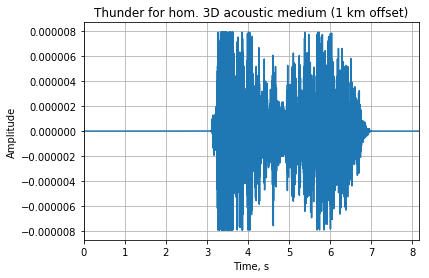

In [9]:
# Plotting Seismogram at 1 km offset
plt.plot(time, G3_seis_1km)
plt.title("Thunder for hom. 3D acoustic medium (1 km offset)" )
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.xlim((0, tmax))
plt.grid()
plt.show()

... reveal a time shift of the thunder source wavelet by 3 s. This is consistent with the basic rule, that you can calculate the distances to a flash by counting the seconds between the arrival of flash and thunder. Every 3 s correspond to approximately 1 km distance. 

Check this rule, by listening to the seismogram recordings. The appearance of the flash is not as impressive as in nature. In this case it corresponds to the click of the mouse on the play button. 

At 1 m offset, which means your are most likely hit by lightning if you are sitting outside with your laptop, you should notice no time-delay between flash and thunder:

In [10]:
Audio(G3_seis_1m, rate=rate)

If you are 1 km away from the flash you should, depending on how accurately you can count 1 s, estimate a time delay  of 3 s

In [11]:
Audio(G3_seis_1km, rate=rate)

As I mentioned approximately 1e10 times during the class: simple theoretical physics is able to predict the future.

While the time-delay is described correctly, the `Audio` function does not seem to correctly reproduce the amplitude decay of the thunder due to **3D geometrical spreading**. The reason for this problem is most likely due to a normalization of the seismogram, before played by the `Audio` function. 

We can get correct the relative amplitude behaviour by adding a spike with the maximum amplitude of the seismogram at 1 m offset to the seismogram at 1 km offset

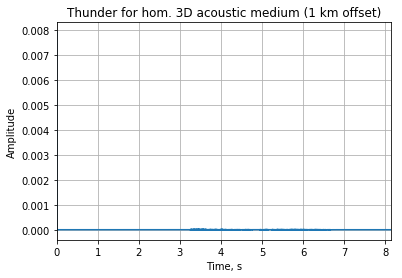

In [12]:
# Estimate maximum amplitude seismogram at 1 m offset
amp_max_1m = np.amax(G3_seis_1m)

# Add spike at first time sample of seismogram at 1 km 
# offset with maximum amplitude amp_max_0km
G3_seis_1km[0] = amp_max_1m

plt.plot(time, G3_seis_1km)
plt.title("Thunder for hom. 3D acoustic medium (1 km offset)" )
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.xlim((0, tmax))
plt.grid()
plt.show()

Wow, notice that the amplitude decay due to geometrical spreading over a distance of 1 km is quite significant. We can barely spot the thunder wavelet. To hear the thunder, you have to turn the volume of your loud speaker to the maximum **(Do not forget to turn it back after the next notebook cell)**.

In [13]:
Audio(G3_seis_1km, rate=rate)

In order to hear thunder at 1 km distance, the source amplitude has to be quite large.

## Thunderstorm in 1D acoustic medium

Similar to the 3D medium, we can desribe the **1D Green's function** $\mathbf{G_1(x,t;x_s,t_s)}$ for a homogenous 1D acoustic medium with constant P-wave velocity $V_{p0}$ by the partial differential equation:

\begin{equation}
\frac{\partial^2 G_1}{\partial t^2} - V_{p0}^2 \frac{\partial^2 G_1}{\partial x^2} = \delta(t-t_s) \delta(x-x_s)
\notag
\end{equation}

The solution is:

\begin{equation}
G_1(x,t)=\dfrac{1}{2V_{p0}}H\biggl((t-t_s)-\dfrac{|x-x_s|}{V_{p0}}\biggr),\nonumber
\nonumber 
\end{equation}

with the Heaviside function

$$
H(x) = \left\{
\begin{array}{ll}
	0 &x<0 \\
	1 &x\geq 0 	
\end{array}
\right.
$$

So the 1D Green's function for the homogeneous acoustic medium is basically a Heaviside distribution delayed by the traveltime between source and receiver.

Similar to the 3D acoustic medium, we can write a function to compute seismograms in a homogeneous 1D acoustic medium:

In [14]:
def calc_seis_1D(xr,tmax,nt,thunder):

    # Define P-wave velocity of air (m/s)
    vp0 = 333.

    # Acquisition geometry
    ts = 0                  # source time shift
    xs = 0                  # spatial source shift
    
    # Computation of 1D Green's function 
    G1=np.zeros(nt)                                # initialization G with zeros
    for i in range (nt):
        
        if (((time[i]-ts)-abs(xr-xs)/vp0)>=0):
            G1[i]=1./(2*vp0)
        else:
            G1[i]=0
    
    # Computation of seismograms for given source wavelet
    G1_seis = np.convolve(G1,thunder)
    G1_seis = G1_seis[0:nt]

    return G1_seis    

Computation and visualization of seismogram recordings at 0 km and 1 km reveal ...

In [15]:
# maximum seismogram recording time
tmax = 2.0 * tmax_src   

# Define time vector
time = np.arange(0,tmax,dt)
nt = len(time)

# calculate seismograms at 1 m and 1 km offset
G1_seis_1m = calc_seis_1D(1.0,tmax,nt,thunder)
G1_seis_1km = calc_seis_1D(1000.0,tmax,nt,thunder)

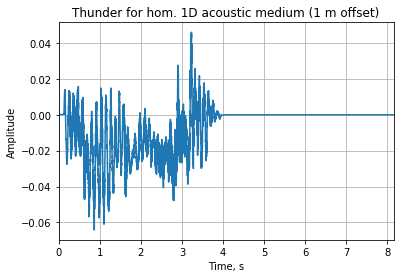

In [16]:
# Plotting Seismogram at 1 m offset
plt.plot(time, G1_seis_1m)
plt.title("Thunder for hom. 1D acoustic medium (1 m offset)" )
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.xlim((0, tmax))
plt.grid()
plt.show()

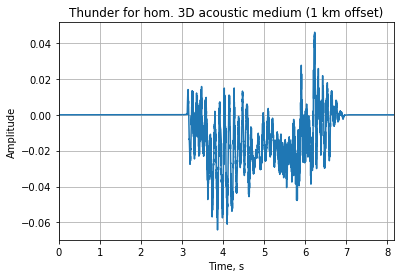

In [17]:
# Plotting Seismogram at 1 km offset
plt.plot(time, G1_seis_1km)
plt.title("Thunder for hom. 3D acoustic medium (1 km offset)" )
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.xlim((0, tmax))
plt.grid()
plt.show()

... quite different waveforms due to the wavelet integration character of the 1D acoustic medium. Let 's listen how the 1D thunder sounds at 1 m offset

In [18]:
Audio(G1_seis_1m, rate=rate)

compared to the 3D thunder

In [19]:
Audio(G3_seis_1m, rate=rate)

Notice, that the high-frequency content of the 1D seismogram seem to be suppressed due to the low-pass filter character of the thunder source wavelet integration during 1D wave propagation. While the waveform changed, the time-delay in the 1D medium remains identical to the 3D medium. At 1 km offset, you still get a 3 s time-delay between flash and thunder

In [20]:
Audio(G1_seis_1km, rate=rate)

Similar to the 3D medium, we can normalize the relative amplitude difference, by adding a spike with the maximum amplitude of the seismogram at 1 m offset to the first sample of the time series of the seismogram at 1 km distance.

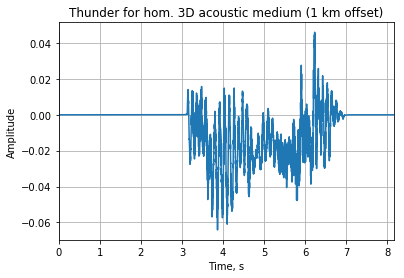

In [21]:
# Estimate maximum amplitude seismogram at 1 m offset
amp_max_1m = np.max(G1_seis_1m)

# Add spike at first time sample of seismogram at 1 km 
# offset with maximum amplitude amp_max_0km
G1_seis_1km[0] = amp_max_1m

plt.plot(time, G1_seis_1km)
plt.title("Thunder for hom. 3D acoustic medium (1 km offset)" )
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.xlim((0, tmax))
plt.grid()
plt.show()

The resulting seismogram at 1 km offset has the same amplitude as the seismogram at zero-offset, due to the **lack of geometrical spreading in 1D media**. Listen to the recordings at 1 m offset

In [22]:
Audio(G1_seis_1m, rate=rate)

and 1 km offset with correct relative amplitudes

In [23]:
Audio(G1_seis_1km, rate=rate)

## We learned:

* How to import wav-files into Python
* How to 'play' numpy-arrays on your speaker
* The 3D analytical seismograms for the propagation of the thunder source wavelet in a homogeneous acoustic medium describes the correct time-delay between flash and thunder at an arbritary offset. Obviously we assumed a homogeneous medium and neglected any echos
* The 3D amplitude decay due to geometrical spreading is quite significant
* Wave propagation in 1D acoustic media is different to 3D media, due to ...

... the lack of geometrical spreading. Therefore, every whisper in the 1D universe would be audible at any place in the 1D universe

... the integration of the waveform during 1D wave propagation acts as a low-pass filter and therefore suppresses high frequency content of the source wavelet